# Apredizagem de Máquina na Detecção de Fraude em Cartões de Crédito

## Instalação de Pacotes
### Importação de Bibliotecas

In [ ]:
%%capture
# Leitura, manipulação, e analise exploratoria dos dados
import seaborn as sns
from google.colab import drive
!pip install dataprep
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Limpeza e Pré - Processamento dos dados

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Bibliotecas de aprendizagem de máquina (Classificação)

from sklearn.svm import SVC # Suporte Vetor Machine
from sklearn.linear_model import LogisticRegression # Regressão Logística
from sklearn.tree import DecisionTreeClassifier # Árvore de decisão (Decision tree learning)
from sklearn.neighbors import KNeighborsClassifier #KNN - K-ésimo Vizinho mais Próximo (k-nearest neighbors algorithm)
from sklearn.neural_network import MLPClassifier # Rede Neural - Perceptron multicamadas
from sklearn.ensemble import RandomForestClassifier # Floresta aleatória (Random forest)
from sklearn.ensemble import GradientBoostingClassifier # Gradient boosting
from xgboost import XGBClassifier # Xgboost
from lightgbm import LGBMClassifier # Light Gradient Boosting Model (LGBM)
import warnings
warnings.filterwarnings("ignore")


### Conectando ao Google drive (acesso ao banco de dados)

In [ ]:
%%capture
drive.mount('/content/drive')

### Leitura do banco de dados

In [ ]:
%%capture
atual_dados = pd.read_csv('/content/drive/Shareddrives/Dados/Detecção de Fraudes em Cartão de Crédito/dados_app_T.CSV', sep = ';', encoding = 'latin-1')
atual_dados

## Limpeza / Pré - Processamento dos Dados

O pré-processamento de dados desempenha um papel fundamental na análise de dados e no desenvolvimento de modelos de aprendizado de máquina. É um conjunto de etapas que visa melhorar a qualidade, a integridade e a confiabilidade dos dados, preparando-os para análises subsequentes. Essas etapas incluem desde a limpeza dos dados até a transformação e a redução da dimensionalidade.

In [ ]:
## Informações das variaveis que vamos trabalhar
# São 122 colunas com as variaveis de cada cliente, sendo que 120 consideramos variáveis explicativas, contendo 307511 linhas com transações
# Obs: Temos variaveis do tipo flutuante, inteira e objeto
%%capture
atual_dados.info('columns')

In [ ]:
# Retirada de colunas
%%capture
atual_dados.drop(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DIAS_EMPREGADOS", "DIAS_REGISTRO", "DIAS_ID_REGISTRO"], axis=1, inplace= True)
atual_dados.info()


In [ ]:
###     Função que retorna os totais e porcentagens de valores nulos, quantidade de valores unicos, e os tipos das variaveis: ###

def meta_data(atual_dados):
    total = atual_dados.isnull().sum()
    percent = (atual_dados.isnull().sum()/atual_dados.isnull().count()*100)
    unique = atual_dados.nunique()
    datatypes = atual_dados.dtypes
    return pd.concat([total, percent, unique, datatypes], axis=1, keys=['Total', 'Percent', 'Unique', 'Data_Type']).sort_values(by="Percent", ascending=False)

app_meta_data=meta_data(atual_dados)
app_meta_data.head(50)

,Total,Percent,Unique,Data_Type
COMMONAREA_AVG,214865,69.872297,3181,float64
COMMONAREA_MODE,214865,69.872297,3128,float64
COMMONAREA_MEDI,214865,69.872297,3202,float64
NONLIVINGAPARTMENTS_MODE,213514,69.432963,167,float64
NONLIVINGAPARTMENTS_AVG,213514,69.432963,386,float64
NONLIVINGAPARTMENTS_MEDI,213514,69.432963,214,float64
FONDKAPREMONT_MODE,210295,68.386172,4,object
LIVINGAPARTMENTS_MEDI,210199,68.354953,1097,float64
LIVINGAPARTMENTS_MODE,210199,68.354953,736,float64
LIVINGAPARTMENTS_AVG,210199,68.354953,1868,float64


In [ ]:
# Removendo linhas que contem dados faltantes

atual_dados2 = atual_dados.dropna()
shape_before = atual_dados.shape[0]
shape_curr = atual_dados.dropna().shape[0]
print("{} linhas foram removidas, o que é equivalente a {}% do dataset".format(shape_before-shape_curr, 100-(shape_curr*100/shape_before)))
atual_dados2.info('columns')

# OBS: Foi retirado todas linhas que por algum motivo tinha dados faltantes em uma das variaveis em estudo.
#O equivalente a 16% apenas do banco de dados foi aproveitado, o que me deixou um pouco precopado em relação a essa exclusão.

260739 linhas foram removidas, o que é equivalente a 84.79013758857407% do dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46772 entries, 0 to 307489
Data columns (total 116 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    Id_EMPRESTIMO                 int64  
 1    ALVO                          int64  
 2    NOME_TIPO_CONTRATO            object 
 3    GENERO                        object 
 4    CARRO                         int64  
 5    CASA_APART                    int64  
 6    QTD_FILHOS                    int64  
 7    RENDA_CLIENTE                 float64
 8    VALOR_EMPRESTIMO              float64
 9    ANUIDADE_EMPRESTIMO           float64
 10   PRECO_BENS                    float64
 11   TIPO_ACOMPANHANTE             object 
 12   TIPO_RENDA                    object 
 13   NIVEL_EDU                     object 
 14   SIT_FAMILIAR                  object 
 15   HABITACAO                     object 
 16   REGIAO_P

In [ ]:
# Verificando lindas duplicadas no banco de dados
atual_dados2.duplicated()

0         False
1         False
13        False
18        False
22        False
          ...  
307456    False
307462    False
307465    False
307482    False
307489    False
Length: 46772, dtype: bool

In [ ]:
atual_dados2

,Id_EMPRESTIMO,ALVO,NOME_TIPO_CONTRATO,GENERO,CARRO,CASA_APART,QTD_FILHOS,RENDA_CLIENTE,VALOR_EMPRESTIMO,ANUIDADE_EMPRESTIMO,...,DOC_18,DOC_19,DOC_20,DOC_21,AMT_REQ_CREDIT_BUREAU_HORA,AMT_REQ_CREDIT_BUREAU_DIA,AMT_REQ_CREDIT_BUREAU_SEMANA,AMT_REQ_CREDIT_BUREAU_MES,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_ANO
0,100002,1,emprestimo_dinheiro,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,emprestimo_dinheiro,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
13,100017,0,emprestimo_dinheiro,M,1,0,1,225000.0,918468.0,28966.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
18,100022,0,emprestimo_rotativo,F,0,1,0,112500.0,157500.0,7875.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
22,100026,0,emprestimo_dinheiro,F,0,0,1,450000.0,497520.0,32521.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307456,456195,0,emprestimo_dinheiro,F,1,1,0,94500.0,270000.0,15075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
307462,456201,0,emprestimo_dinheiro,F,1,1,3,135000.0,1024785.0,57222.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
307465,456205,0,emprestimo_dinheiro,F,0,0,1,180000.0,835380.0,33259.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
307482,456226,0,emprestimo_dinheiro,F,1,1,0,225000.0,500566.5,34969.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


### Análise descritiva Geral


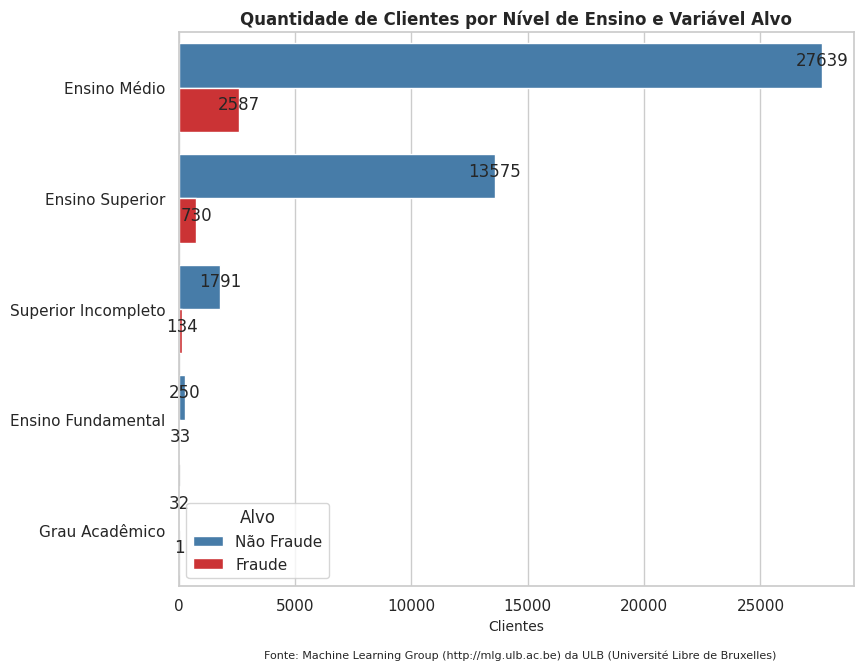

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

label_map = {
    'ensino_medio': 'Ensino Médio',
    'ensino_superior': 'Ensino Superior',
    'superior_incompleto': 'Superior Incompleto',
    'ensino_fundamental': 'Ensino Fundamental',
    'grau_academico': 'Grau Acadêmico'
}

labels = [label_map.get(category) for category in atual_dados2['NIVEL_EDU'].unique()]

# Inverta a ordem das cores na paleta Set1
custom_palette = sns.color_palette("Set1", n_colors=2)[::-1]

ax = sns.countplot(y="NIVEL_EDU", hue="ALVO", data=atual_dados2, palette=custom_palette)

ax.set_yticklabels(labels)

plt.xlabel("Clientes", fontsize=10)
plt.ylabel("", fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), (p.get_width() + 10, p.get_y() + p.get_height() / 2), ha='center', fontsize=12)

plt.title("Quantidade de Clientes por Nível de Ensino e Variável Alvo", fontsize=12, fontweight='bold')

# Adicione a legenda personalizada
plt.legend(title="Alvo", labels=["Não Fraude", "Fraude"])

plt.figtext(0.6, -0.01, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_Quantidade_Clientes_Escolaridade_Alvo.png', dpi=300, bbox_inches='tight')

plt.show()

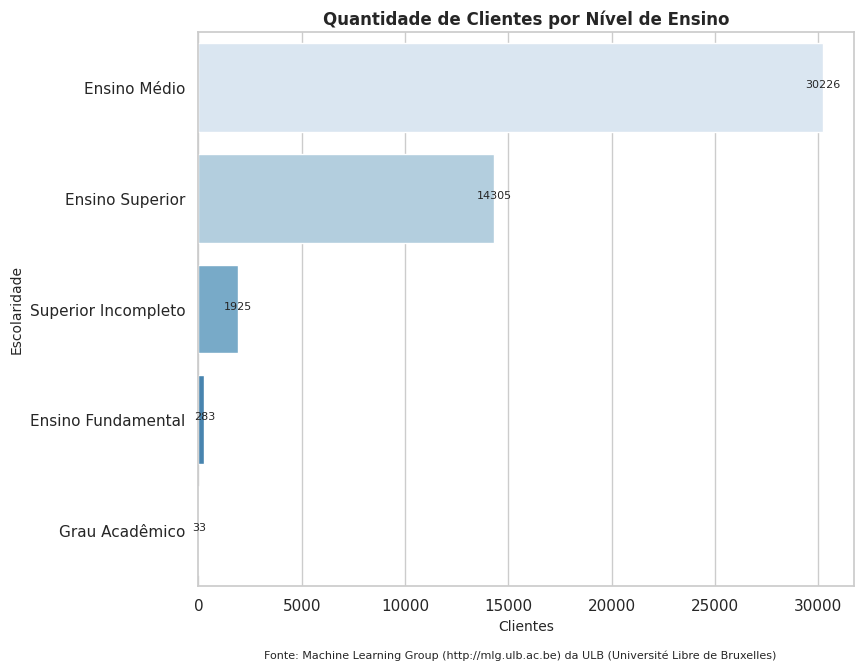

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

label_map = {
    'ensino_medio': 'Ensino Médio',
    'ensino_superior': 'Ensino Superior',
    'superior_incompleto': 'Superior Incompleto',
    'ensino_fundamental': 'Ensino Fundamental',
    'grau_academico': 'Grau Acadêmico'
}

labels = [label_map.get(category) for category in atual_dados2['NIVEL_EDU'].unique()]

ax = sns.countplot(y="NIVEL_EDU", data=atual_dados2, palette="Blues")

ax.set_yticklabels(labels)

plt.xlabel("Clientes", fontsize=10)
plt.ylabel("Escolaridade", fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), (p.get_width() + 10, p.get_y() + p.get_height() / 2), ha='center', fontsize=8)

plt.title("Quantidade de Clientes por Nível de Ensino", fontsize=12, fontweight='bold')

plt.figtext(0.6, -0.01, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_Quantidade_Clientes_Escolaridade.png', dpi=300, bbox_inches='tight')


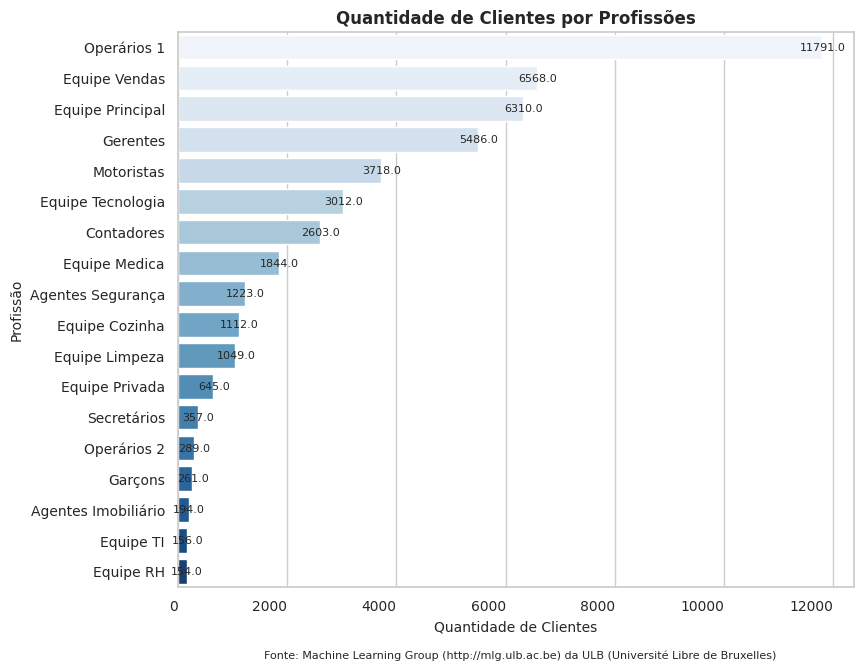

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

# Renomear as categorias da variável PROFISSAO
profissoes_renomeadas = atual_dados2['PROFISSAO'].replace({
    'operario': 'Operários 1',
    'equipe_vendas': 'Equipe Vendas',
    'equipe_principal': 'Equipe Principal',
    'gerente': 'Gerentes',
    'motorista': 'Motoristas',
    'equipe_tecnologia': 'Equipe Tecnologia',
    'contador': 'Contadores',
    'equipe_medica': 'Equipe Medica',
    'agente_seguranca': 'Agentes Segurança',
    'equipe_cozinha': 'Equipe Cozinha',
    'equipe_limpeza': 'Equipe Limpeza',
    'equipe_privada': 'Equipe Privada',
    'secretario': 'Secretários',
    'operario_0': 'Operários 2',
    'garcon': 'Garçons',
    'agente_imobiliario': 'Agentes Imobiliário',
    'equipe_ti': 'Equipe TI',
    'equipe_rh': 'Equipe RH'
})

# Ordenar as barras em ordem decrescente
profissao_counts = profissoes_renomeadas.value_counts()
ax = sns.countplot(y=profissoes_renomeadas, order=profissao_counts.index, palette="Blues")

# Rotular as barras
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 10, p.get_y() + p.get_height() / 2, f"{width}", ha='center', va='center', fontsize=8)

plt.xlabel("Quantidade de Clientes", fontsize=10)
plt.ylabel("Profissão", fontsize=10)

# Título do gráfico
plt.title("Quantidade de Clientes por Profissões", fontsize=12, fontweight='bold')

# Ajustar o tamanho das fontes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Rotacionar os rótulos do eixo y, se necessário
plt.xticks(rotation=0, ha='right')

# Fonte do gráfico
plt.figtext(0.6, -0.01, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_Quantidade_Clientes_Profissoes.png', dpi=300, bbox_inches='tight')


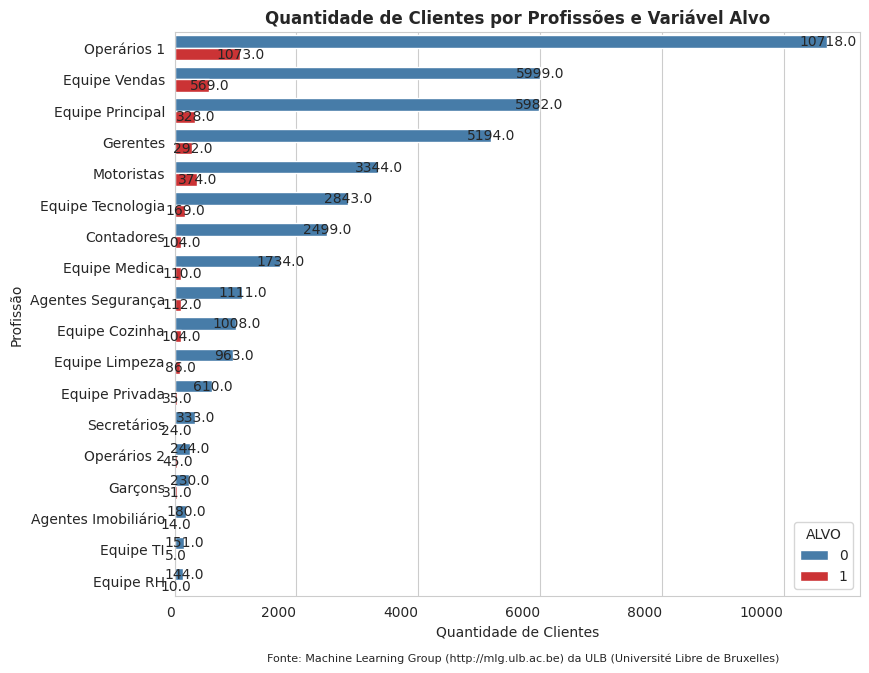

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

# Renomear as categorias da variável PROFISSAO
profissoes_renomeadas = atual_dados2['PROFISSAO'].replace({
    'operario': 'Operários 1',
    'equipe_vendas': 'Equipe Vendas',
    'equipe_principal': 'Equipe Principal',
    'gerente': 'Gerentes',
    'motorista': 'Motoristas',
    'equipe_tecnologia': 'Equipe Tecnologia',
    'contador': 'Contadores',
    'equipe_medica': 'Equipe Medica',
    'agente_seguranca': 'Agentes Segurança',
    'equipe_cozinha': 'Equipe Cozinha',
    'equipe_limpeza': 'Equipe Limpeza',
    'equipe_privada': 'Equipe Privada',
    'secretario': 'Secretários',
    'operario_0': 'Operários 2',
    'garcon': 'Garçons',
    'agente_imobiliario': 'Agentes Imobiliário',
    'equipe_ti': 'Equipe TI',
    'equipe_rh': 'Equipe RH'
})

# Ordenar as barras em ordem decrescente
profissao_counts = profissoes_renomeadas.value_counts()

# Inverta a ordem das cores na paleta Set1
custom_palette = sns.color_palette("Set1", n_colors=2)[::-1]

ax = sns.countplot(y=profissoes_renomeadas, hue=atual_dados2['ALVO'], order=profissao_counts.index, palette=custom_palette)

# Rotular as barras
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 10, p.get_y() + p.get_height() / 2, f"{width}", ha='center', va='center', fontsize=10)

plt.xlabel("Quantidade de Clientes", fontsize=10)
plt.ylabel("Profissão", fontsize=10)

# Título do gráfico
plt.title("Quantidade de Clientes por Profissões e Variável Alvo", fontsize=12, fontweight='bold')

# Ajustar o tamanho das fontes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Rotacionar os rótulos do eixo y, se necessário
plt.xticks(rotation=0, ha='right')

# Fonte do gráfico
plt.figtext(0.6, -0.01, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_Quantidade_Clientes_Profissoes_Alvo.png', dpi=300, bbox_inches='tight')

plt.show()


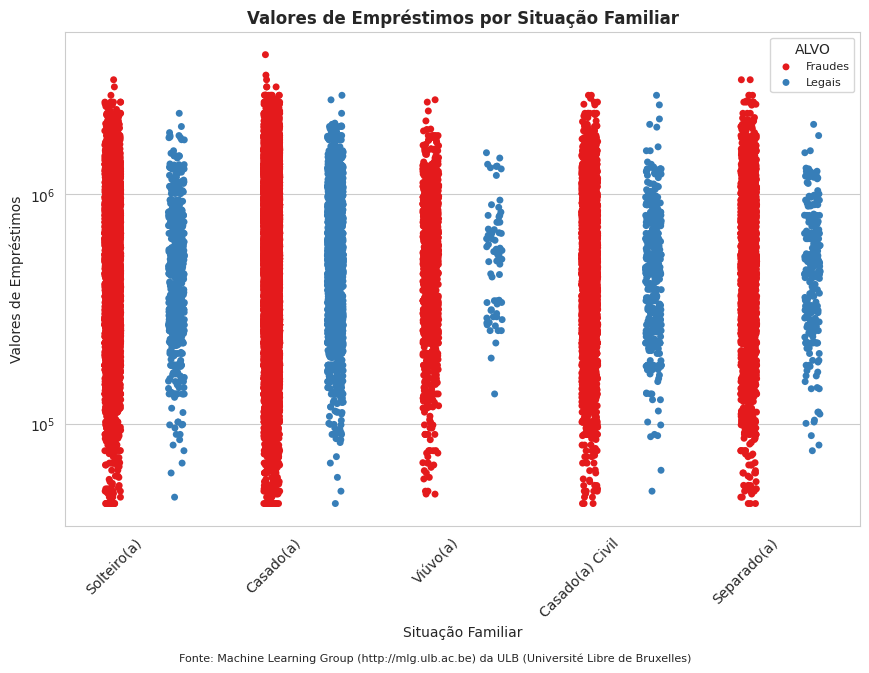

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

# Renomear as categorias da variável SIT_FAMILIAR
sit_familiar_renomeada = atual_dados2['SIT_FAMILIAR'].replace({
    'solteiro': 'Solteiro(a)',
    'casado': 'Casado(a)',
    'viuva': 'Viúvo(a)',
    'casado_civil': 'Casado(a) Civil',
    'separado': 'Separado(a)',
})

# Ajustar a escala do eixo y
plt.yscale('log')  # ou 'linear', dependendo dos dados

# Plotar o gráfico de stripplot
splot = sns.stripplot(y="VALOR_EMPRESTIMO", x=sit_familiar_renomeada, hue="ALVO", data=atual_dados2, dodge=True, palette="Set1")

plt.xlabel("Situação Familiar", fontsize=10)
plt.ylabel("Valores de Empréstimos", fontsize=10)

# Título do gráfico
plt.title("Valores de Empréstimos por Situação Familiar", fontsize=12, fontweight='bold')

# Ajustar o tamanho das fontes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Rotacionar os rótulos do eixo x, se necessário
plt.xticks(rotation=45, ha='right')

# Adicionar legenda
plt.legend(title="ALVO", labels=["Fraudes", "Legais"], fontsize=8)

# Fonte do gráfico
plt.figtext(0.5, -0.01, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_SituacaoFamiliar_ValorEmprestimo_Sexo.png', dpi=300, bbox_inches='tight')

plt.show()


### Análisde descritiva Finanças


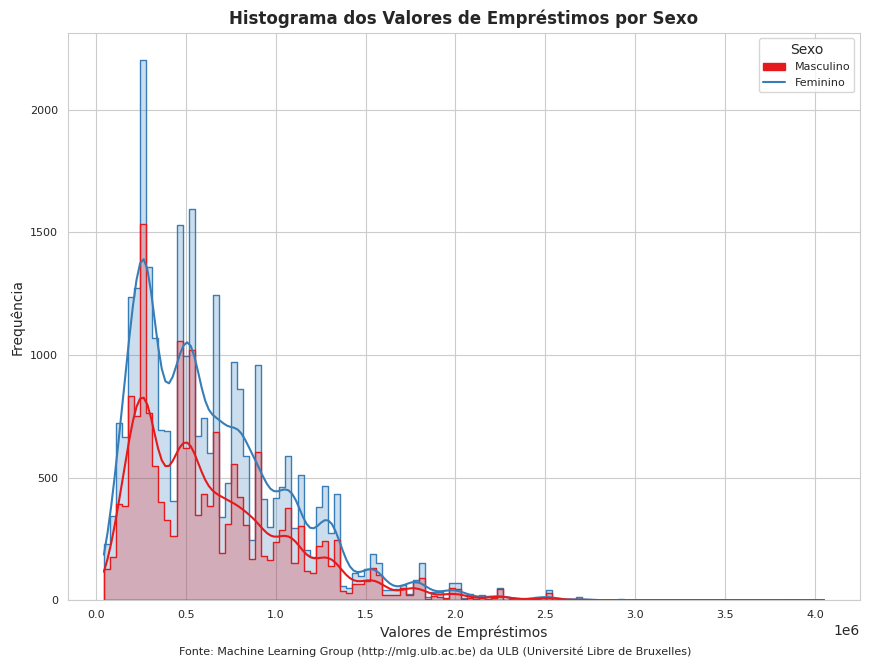

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

sns.histplot(x="VALOR_EMPRESTIMO",
             kde=True,
             hue="GENERO",
             data=atual_dados2,
             palette="Set1",  # Utilizar as cores da paleta Set1 para as barras e a legenda
             element="step")  # Definir o estilo das barras

legend_labels = ["Masculino", "Feminino"]
legend = plt.legend(title="Sexo", labels=legend_labels, fontsize=8)

# Definir as cores dos retângulos na legenda usando a paleta Set1
for handle, color in zip(legend.legendHandles, sns.color_palette("Set1")):
    handle.set_color(color)

plt.xlabel("Valores de Empréstimos", fontsize=10)
plt.ylabel("Frequência", fontsize=10)

plt.title("Histograma dos Valores de Empréstimos por Sexo", fontsize=12, fontweight='bold')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.figtext(0.5, -0.00001, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_ValoresEmprestimos_Sexo.png', dpi=300)
plt.show()


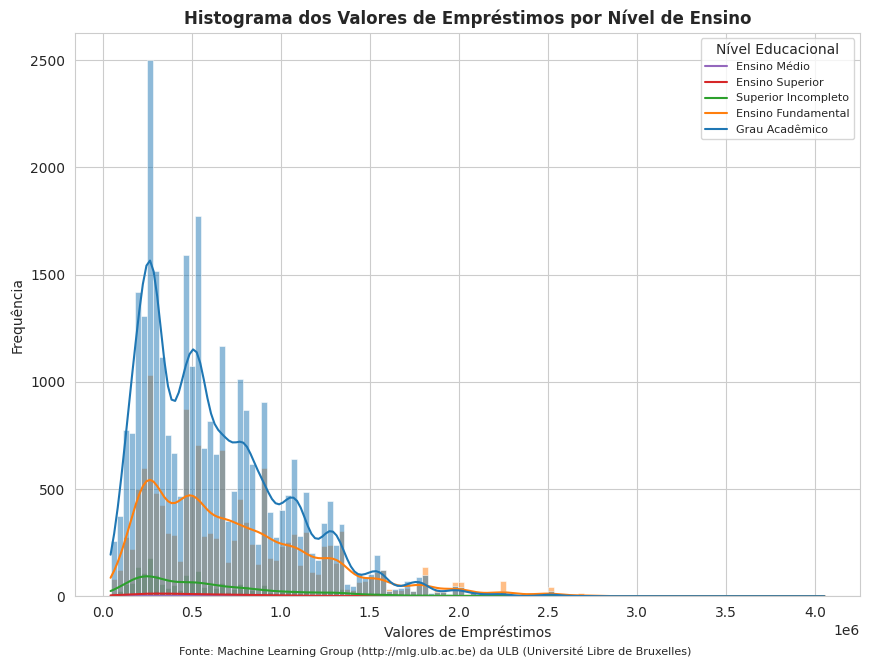

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

sns.histplot(x="VALOR_EMPRESTIMO",
             kde=True,
             hue="NIVEL_EDU",
             data=atual_dados2,
             palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])

label_map = {
    'ensino_medio': 'Ensino Médio',
    'ensino_superior': 'Ensino Superior',
    'superior_incompleto': 'Superior Incompleto',
    'ensino_fundamental': 'Ensino Fundamental',
    'grau_academico': 'Grau Acadêmico'
}

labels = [label_map.get(category) for category in atual_dados2['NIVEL_EDU'].unique()]
plt.legend(title="Nível Educacional", labels=labels, fontsize=8)

plt.xlabel("Valores de Empréstimos")
plt.ylabel("Frequência")

plt.title("Histograma dos Valores de Empréstimos por Nível de Ensino", fontsize=12, fontweight='bold')

plt.figtext(0.5, -0.00001, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_ValoresEmpréstimos_por_Nível_Ensino.png', dpi=300)


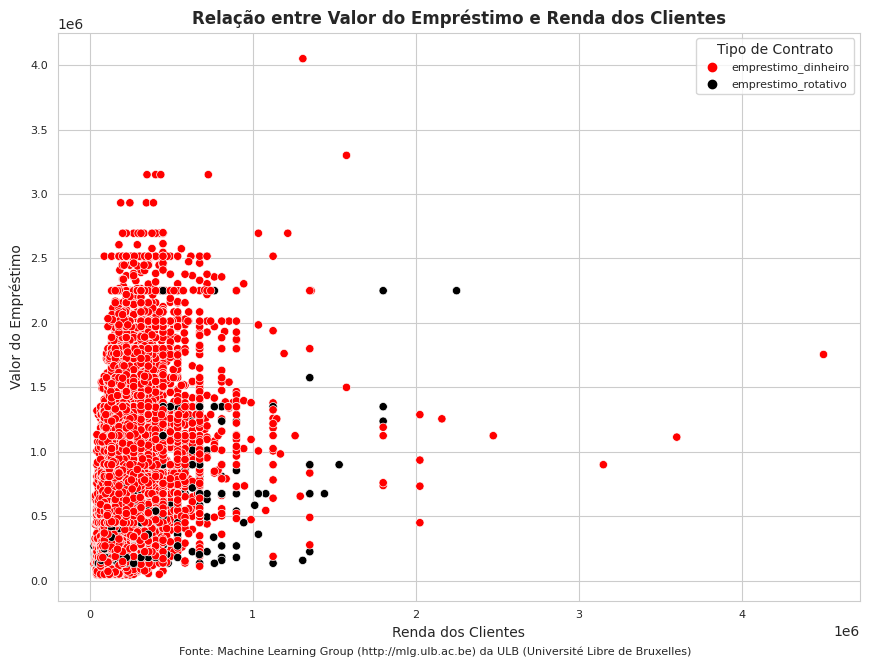

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

graf_disp = sns.scatterplot(data=atual_dados2,
                            x="RENDA_CLIENTE",
                            y="VALOR_EMPRESTIMO",
                            hue="NOME_TIPO_CONTRATO",
                            palette=["red", "black"],
                            legend="full")

plt.xlabel("Renda dos Clientes", fontsize=10)
plt.ylabel("Valor do Empréstimo", fontsize=10)
plt.title("Relação entre Valor do Empréstimo e Renda dos Clientes", fontsize=12, fontweight='bold')

# Ajustar o tamanho da legenda
plt.legend(title="Tipo de Contrato", fontsize=8)

# Ajustar o tamanho das marcações no gráfico
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Ajustar o tamanho do título
plt.title("Relação entre Valor do Empréstimo e Renda dos Clientes", fontsize=12, fontweight='bold')

# Ajustar a posição e o tamanho da fonte da fonte da legenda
plt.figtext(0.5, -0.00001, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_Relacao_Valor_Emprestimo_Renda_Clientes.png', dpi=300)


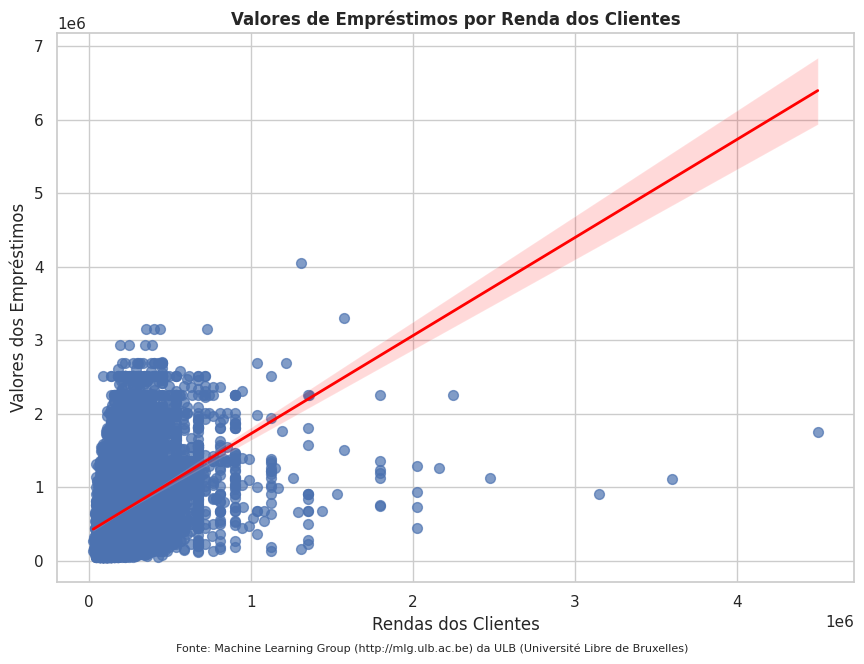

In [ ]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8.8, 6.6))

sns.regplot(data=atual_dados2,
            x="RENDA_CLIENTE",
            y="VALOR_EMPRESTIMO",
            scatter_kws={"alpha": 0.7, "s": 50},
            line_kws={"color": "red", "lw": 2})

plt.title("Valores de Empréstimos por Renda dos Clientes", fontsize=12, fontweight='bold')
plt.xlabel("Rendas dos Clientes")
plt.ylabel("Valores dos Empréstimos")

# Fonte do gráfico
plt.figtext(0.5, -0.00001, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)


plt.tight_layout()
plt.savefig('Grafico_ValoresEmprestimos_RendasClientes.png', dpi=300)
plt.show()


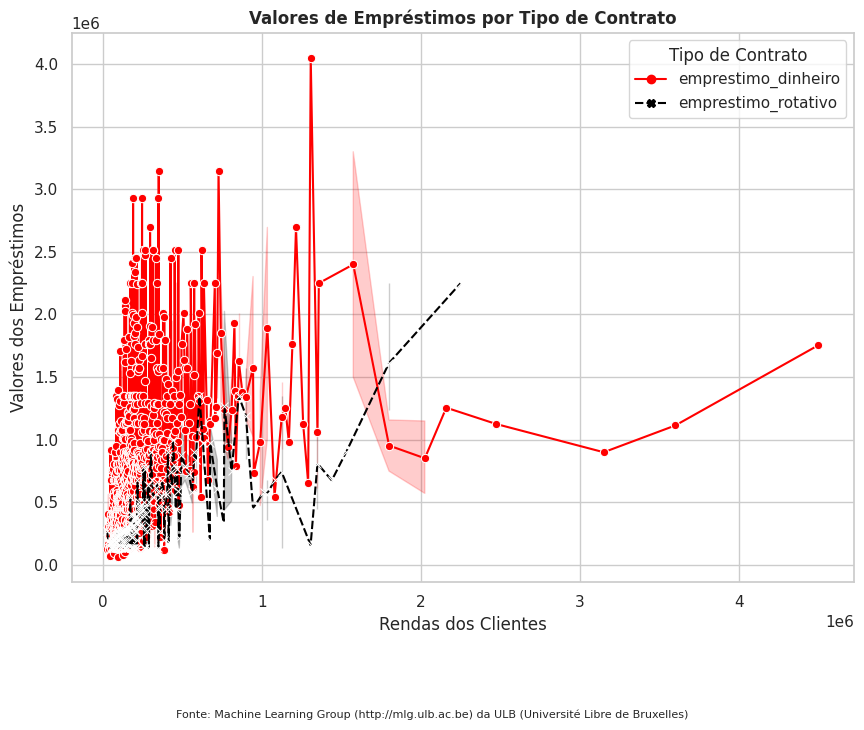

In [ ]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8.8, 6.6))

sns.lineplot(data=atual_dados2,
             x="RENDA_CLIENTE",
             y="VALOR_EMPRESTIMO",
             hue="NOME_TIPO_CONTRATO",
             style="NOME_TIPO_CONTRATO",
             markers=True,
             palette=["red", "black"],
             legend="full")

# Definir rótulos para os marcadores
legend_labels = ['Contrato 1', 'Contrato 2']
ax.lines[0].set_marker('o')
ax.lines[1].set_marker('x')
ax.legend(title='Tipo de Contrato', loc='upper right')

plt.title("Valores de Empréstimos por Tipo de Contrato", fontsize=12, fontweight='bold')
plt.xlabel("Rendas dos Clientes")
plt.ylabel("Valores dos Empréstimos")

# Fonte do gráfico
plt.figtext(0.5, -0.1, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_ValoresEmprestimos_RendasClientes.png', dpi=300)
plt.show()


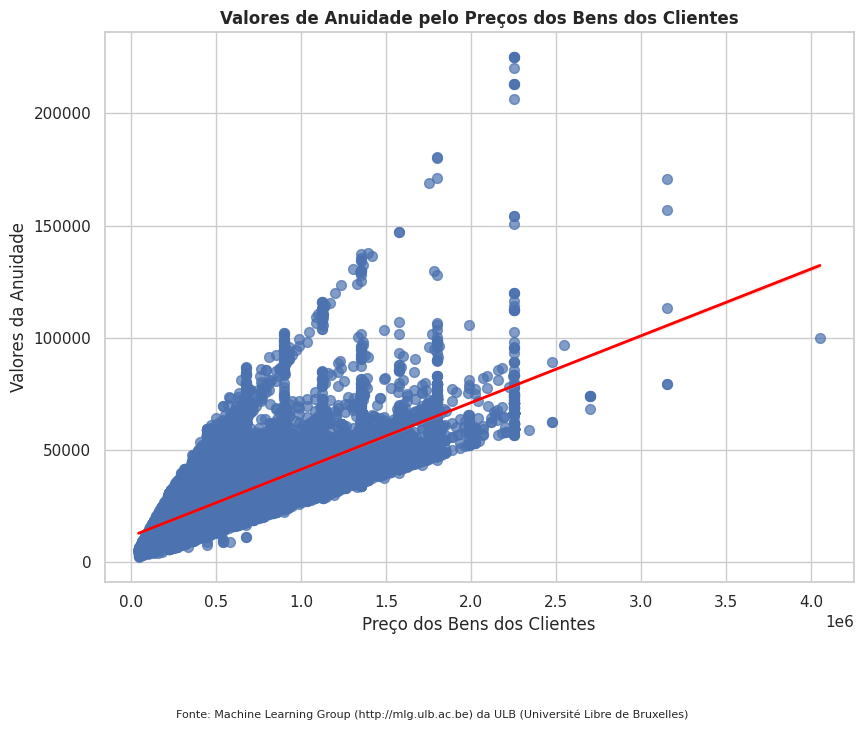

In [ ]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8.8, 6.6))

sns.regplot(data=atual_dados2,
            x="PRECO_BENS",
            y="ANUIDADE_EMPRESTIMO",
            scatter_kws={"alpha": 0.7, "s": 50},
            line_kws={"color": "red", "lw": 2})

plt.title("Valores de Anuidade pelo Preços dos Bens dos Clientes", fontsize=12, fontweight='bold')
plt.xlabel("Preço dos Bens dos Clientes")
plt.ylabel("Valores da Anuidade")

# Fonte do gráfico
plt.figtext(0.5, -0.1, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_ValoresAnuidade_PrecoBens.png', dpi=300)
plt.show()


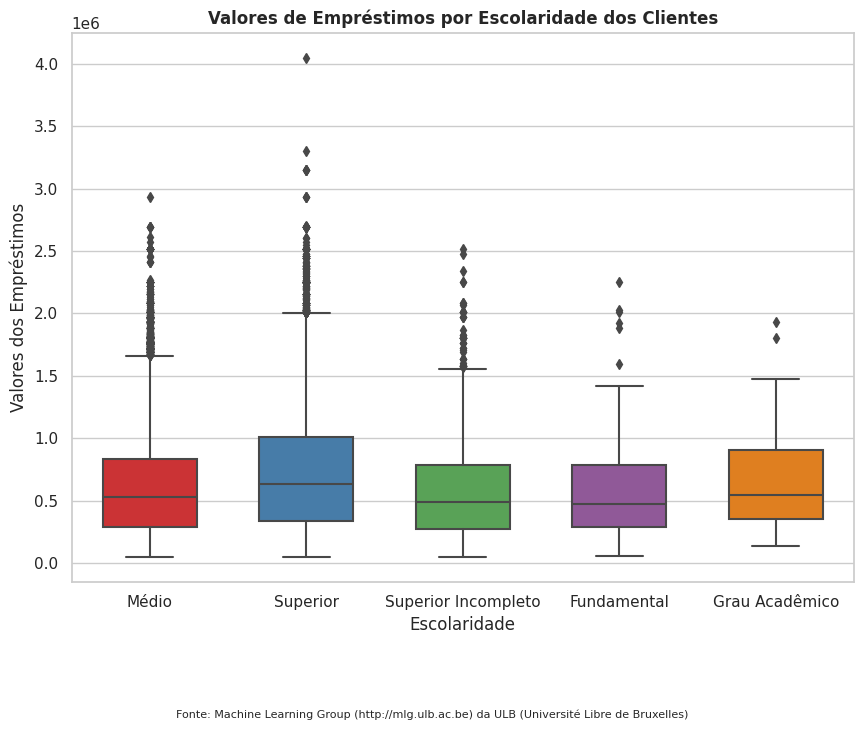

In [ ]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8.8, 6.6))

label_map = {
    'ensino_medio': 'Médio',
    'ensino_superior': 'Superior',
    'superior_incompleto': 'Superior Incompleto',
    'ensino_fundamental': 'Fundamental',
    'grau_academico': 'Grau Acadêmico'
}

labels = [label_map.get(category) for category in atual_dados2['NIVEL_EDU'].unique()]

ax = sns.boxplot(y="VALOR_EMPRESTIMO",
                 x="NIVEL_EDU",
                 data=atual_dados2,
                 width=0.6,
                 palette="Set1")
ax.set_xticklabels(labels)  # Define os rótulos para o eixo x

# Definir rótulos para os eixos
plt.xlabel("Escolaridade")
plt.ylabel("Valores dos Empréstimos")
plt.title("Valores de Empréstimos por Escolaridade dos Clientes", fontsize=12, fontweight='bold')

# Fonte do gráfico
plt.figtext(0.5, -0.1, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_ValoresEmprestimos_Escolaridade.png', dpi=300)
plt.show()


### Análise Descritiva e Exploratória

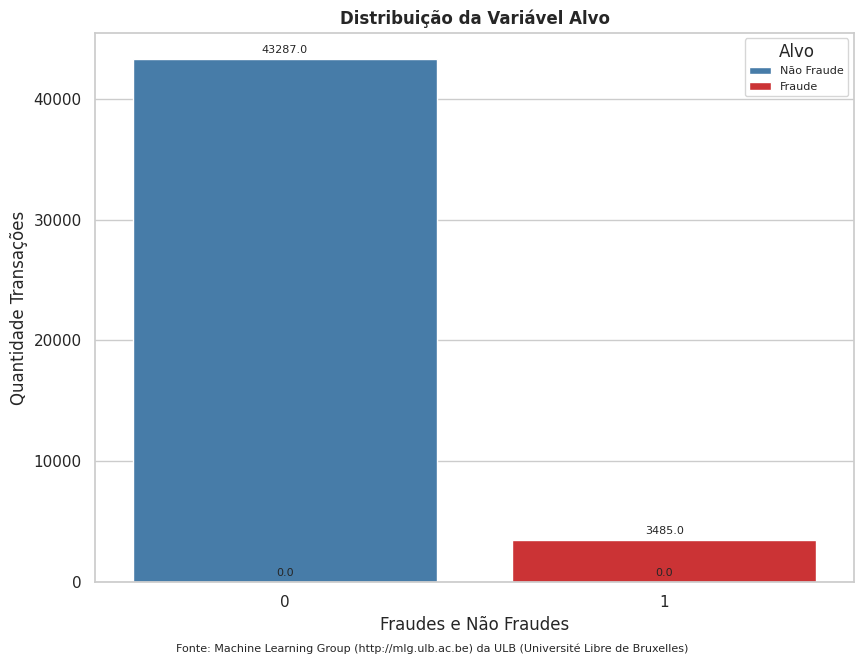

In [ ]:
# Analise de dados considerados fraudes na amostra com todas linhas com dados faltantes retirados, dados desbalanceados

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

# Seu código para criar o gráfico de barras
custom_palette = sns.color_palette("Set1", n_colors=2)[::-1]

sns.countplot(x="ALVO",
              hue='ALVO',
              dodge=False,
              palette= custom_palette,
              data=atual_dados2)

# Definir rótulos para os eixos
plt.ylabel("Quantidade Transações")
plt.xlabel("Fraudes e Não Fraudes")
plt.title("Distribuição da Variável Alvo", fontsize=12, fontweight='bold')

# Definir rótulos da legenda
legend_labels = ["Não Fraude", "Fraude"]
legend = plt.legend(title="Alvo", labels=legend_labels, fontsize=8)

# Fonte do gráfico
plt.figtext(0.5, 0, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)


# Adicionar rótulos nas barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig('Grafico_Distribuicao_Variavel_Alvo1.png', dpi=300)
plt.show()


#OBS: A partir dessas informações, vemos que este é um conjunto de dados desequilibrado. Existe muito mais emprestimos
# que foram pagos no prazo, do que os que não foram pagos.
# No banco como um todo foram mais de 25.000 emprestimos reelbolsados, e menos de 2500 emprestimos atrasaram por
# algum motivo e não foram pagos.


### Análise Descritiva e Exploratória EDA

In [ ]:
# Opção de uma análise rápida automática
#ADE = create_report(atual_dados2, title='My Report')
#ADE

In [ ]:
atual_dados2 = pd.get_dummies(atual_dados2)

In [ ]:
atual_dados2.tail(10)

,Id_EMPRESTIMO,ALVO,CARRO,CASA_APART,QTD_FILHOS,RENDA_CLIENTE,VALOR_EMPRESTIMO,ANUIDADE_EMPRESTIMO,PRECO_BENS,REGIAO_POPULACAO_RELATIVE,...,HOUSETYPE_MODE_bloco_apartamento,HOUSETYPE_MODE_casa_terraco,HOUSETYPE_MODE_habitacao_especifica,WALLSMATERIAL_MODE_bloco,WALLSMATERIAL_MODE_madeira,WALLSMATERIAL_MODE_misto,WALLSMATERIAL_MODE_monolitico,WALLSMATERIAL_MODE_outros,WALLSMATERIAL_MODE_painel,WALLSMATERIAL_MODE_tijolo_pedra
307437,456175,0,1,1,0,81000.0,180000.0,12658.5,180000.0,0.015221,...,1,0,0,0,0,0,0,0,1,0
307438,456176,1,0,1,0,171000.0,1436850.0,42142.5,1125000.0,0.032561,...,1,0,0,0,0,0,0,0,0,1
307439,456177,0,0,1,0,247500.0,900000.0,50386.5,900000.0,0.010006,...,1,0,0,0,0,0,0,0,1,0
307448,456186,1,0,0,1,207000.0,450000.0,32746.5,450000.0,0.020246,...,1,0,0,0,0,0,0,0,0,1
307454,456193,0,0,0,0,157500.0,1332000.0,39078.0,1332000.0,0.008575,...,1,0,0,0,0,0,0,0,0,1
307456,456195,0,1,1,0,94500.0,270000.0,15075.0,270000.0,0.028663,...,1,0,0,0,0,0,0,0,0,1
307462,456201,0,1,1,3,135000.0,1024785.0,57222.0,922500.0,0.008019,...,1,0,0,0,0,0,0,0,0,1
307465,456205,0,0,0,1,180000.0,835380.0,33259.5,675000.0,0.031329,...,1,0,0,1,0,0,0,0,0,0
307482,456226,0,1,1,0,225000.0,500566.5,34969.5,472500.0,0.031329,...,1,0,0,1,0,0,0,0,0,0
307489,456233,1,0,1,0,225000.0,521280.0,23089.5,450000.0,0.014464,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
print(sorted(Counter(atual_dados2['ALVO']).items()))

[(0, 43287), (1, 3485)]


In [ ]:
dataset_stellar = atual_dados2
a = dataset_stellar.loc[:, (dataset_stellar.columns != 'ALVO' ) & (dataset_stellar.columns != 'Id_EMPRESTIMO') ].values
b = dataset_stellar["ALVO"].values

### Balanceamento dos dados (Oversampling)




O balanceamento dos dados é uma técnica essencial em problemas de aprendizado de máquina, especialmente quando há um desequilíbrio significativo entre as classes do conjunto de dados. Neste resumo, abordaremos especificamente a técnica de oversampling, que consiste em aumentar a quantidade de amostras da classe minoritária para equilibrar as classes.

Oversampling como técnica de balanceamento:
O oversampling é uma abordagem amplamente utilizada para lidar com o desbalanceamento de classes. Essa técnica envolve a replicação ou criação de instâncias sintéticas da classe minoritária para aumentar sua representação no conjunto de dados. Ao fazer isso, busca-se mitigar os efeitos negativos do desequilíbrio de classes e melhorar o desempenho dos modelos de aprendizado de máquina.

In [ ]:
%%capture
%%bash
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler (random_state = 0)
a_resampled, b_resampled = ros.fit_resample(a,b)
print(sorted(Counter(b_resampled).items()), b_resampled.shape)

[(0, 43287), (1, 43287)] (86574,)


In [ ]:
a_resampled

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 1., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [ ]:
b_resampled

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
# Criação de dataframe a partir do array de 0 e 1 balanceados para fazer o gráfico:
# Nomes das colunas
nomes_colunas = ['ALVO']

# Criação do DataFrame com os nomes das colunas
df = pd.DataFrame(b_resampled, columns=nomes_colunas)



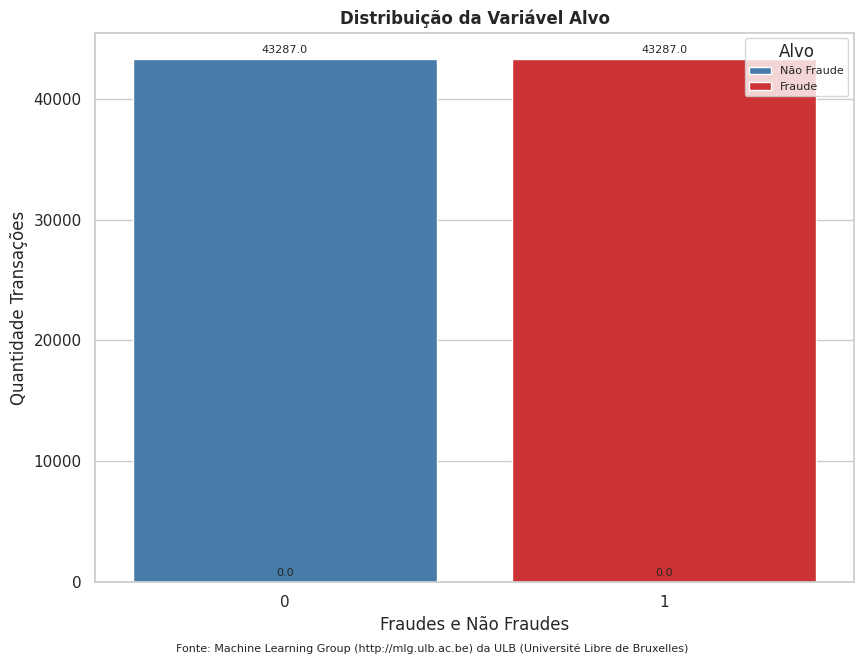

In [ ]:
# Dados balanceados

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

# Seu código para criar o gráfico de barras
custom_palette = sns.color_palette("Set1", n_colors=2)[::-1]
sns.countplot(x="ALVO",
              hue='ALVO',
              dodge=False,
              palette=custom_palette,
              data=df)

plt.ylabel("Quantidade Transações")
plt.xlabel("Fraudes e Não Fraudes")
plt.title("Distribuição da Variável Alvo", fontsize=12, fontweight='bold')

legend_labels = ["Não Fraude", "Fraude"]
legend = plt.legend(title="Alvo", labels=legend_labels, fontsize=8)

plt.figtext(0.5, 0, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

# Adicionar rótulos nas barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_Distribuicao_Variavel_Alvo.png', dpi=300, bbox_inches='tight')
plt.show()

#OBS: A partir dessas informações, vemos que este é um conjunto de dados desequilibrado. Existe muito mais emprestimos
# que foram pagos no prazo, do que os que não foram pagos.
# No banco como um todo foram mais de 25.000 emprestimos reelbolsados, e menos de 2500 emprestimos atrasaram por
# algum motivo e não foram pagos.


### Normalização dos dados

A normalização de dados é uma etapa importante no pré-processamento de dados para modelagem, com o objetivo de garantir que todas as variáveis tenham a mesma escala e reduzir possíveis efeitos negativos de valores discrepantes ou variâncias desiguais entre as variáveis. A normalização é especialmente relevante em algoritmos sensíveis à escala dos dados, como aqueles baseados em distância.

In [ ]:
# Normalização dos dados do tipo [variaveis continuas (float) e discreta (int)]
scale_obj = StandardScaler()
a_resampled = scale_obj.fit_transform(a_resampled.astype(float))
a_resampled = scale_obj.fit_transform(a_resampled.astype(int))

### Separação dos dados em treino e teste

In [ ]:
# Separação dos dados já balanceados em treino e teste
XTrain, XTest, yTrain, yTest = train_test_split(a_resampled, b_resampled, test_size = 0.30)

## Algoritimos de Aprendizagem de Máquina (Classificadores)


### Máquina de vetores de suporte (Vetor Machine)

In [ ]:
clf_svc = SVC()

In [ ]:
clf_svc = clf_svc.fit(XTrain, yTrain)

Acuracia: 
0.8448773726562199

 Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.77      0.91      0.83     11146
           1       0.92      0.80      0.85     14827

    accuracy                           0.84     25973
   macro avg       0.85      0.85      0.84     25973
weighted avg       0.86      0.84      0.85     25973

Confusion Matrix: 

[[10092  1054]
 [ 2975 11852]]


Text(0.5, 1.0, 'Matriz de Confusão')

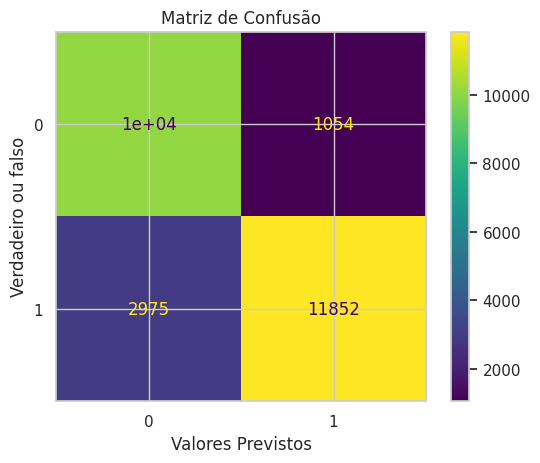

In [ ]:
accuracy_svc = clf_svc.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_svc))
prediction_svc = clf_svc.predict(XTest)
cm_svc = confusion_matrix(prediction_svc, yTest)
cr_svc = classification_report(prediction_svc, yTest)
print('\n Metricas de Classificação: \n')
print(cr_svc)
print('Confusion Matrix: \n')
print(cm_svc)

splot = ConfusionMatrixDisplay.from_predictions(prediction_svc, yTest)

plt.xlabel("Valores Previstos")
plt.ylabel("Verdadeiro ou falso")
plt.title("Matriz de Confusão")


### Regressão Logística

In [ ]:
clf_rl= LogisticRegression()

In [ ]:
clf_rl = clf_rl.fit(XTrain, yTrain)

Acuracia: 
0.6271127709544527
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.60      0.64      0.62     12408
           1       0.65      0.62      0.63     13565

    accuracy                           0.63     25973
   macro avg       0.63      0.63      0.63     25973
weighted avg       0.63      0.63      0.63     25973

Confusion Matrix: 

[[7895 4513]
 [5172 8393]]


Text(0.5, 1.0, 'Matriz de Confusão')

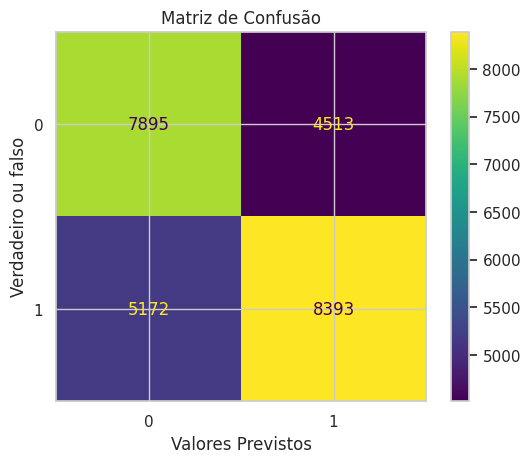

In [ ]:
accuracy_rl = clf_rl.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_rl))
prediction_rl = clf_rl.predict(XTest)
cm_rl = confusion_matrix(prediction_rl, yTest)
cr_rl = classification_report(prediction_rl, yTest)
print('Metricas de Classificação: \n')
print(cr_rl)
print('Confusion Matrix: \n')
print(cm_rl)
splot = ConfusionMatrixDisplay.from_predictions(prediction_rl, yTest)
plt.xlabel("Valores Previstos")
plt.ylabel("Verdadeiro ou falso")
plt.title("Matriz de Confusão")


### Árvore de decisão (Decision tree learning)

In [ ]:
clf_dtl = DecisionTreeClassifier ()

In [ ]:
clf_dtl = clf_dtl.fit(XTrain, yTrain)

Acuracia: 
0.937435028683633
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     11456
           1       1.00      0.89      0.94     14517

    accuracy                           0.94     25973
   macro avg       0.94      0.94      0.94     25973
weighted avg       0.95      0.94      0.94     25973

Confusion Matrix: 

[[11449     7]
 [ 1618 12899]]


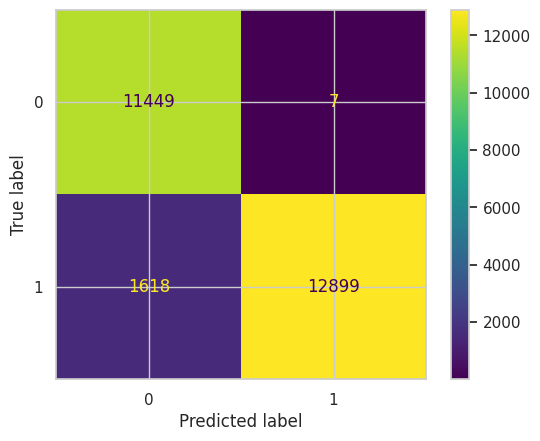

In [ ]:
accuracy_dtl = clf_dtl.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_dtl))

prediction_dtl = clf_dtl.predict(XTest)
cm_dtl = confusion_matrix(prediction_dtl, yTest)
cr_dtl = classification_report(prediction_dtl, yTest)
print('Metricas de Classificação: \n')
print(cr_dtl)
print('Confusion Matrix: \n')
print(cm_dtl)
ConfusionMatrixDisplay.from_predictions(prediction_dtl, yTest)

### KNN - K-ésimo Vizinho mais Próximo (k-nearest neighbors algorithm)

In [ ]:
clf_knn = KNeighborsClassifier()

In [ ]:
clf_knn = clf_knn.fit(XTrain, yTrain)

Acuracia: 
0.8596234551264775
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      9507
           1       1.00      0.78      0.88     16466

    accuracy                           0.86     25973
   macro avg       0.86      0.89      0.86     25973
weighted avg       0.90      0.86      0.86     25973

Confusion Matrix: 

[[ 9464    43]
 [ 3603 12863]]


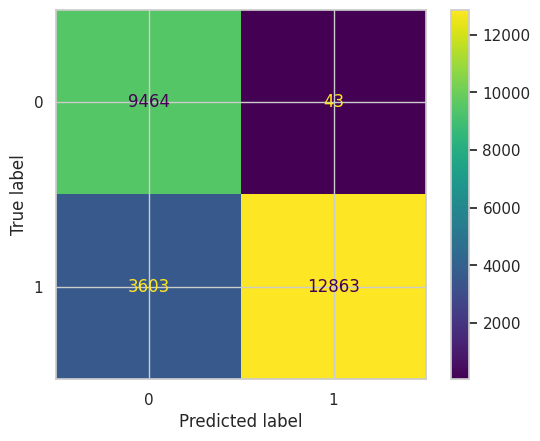

In [ ]:
accuracy_knn = clf_knn.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_knn))
prediction_knn = clf_knn.predict(XTest)
cm_knn = confusion_matrix(prediction_knn, yTest)
cr_knn = classification_report(prediction_knn, yTest)
print('Metricas de Classificação: \n')
print(cr_knn)
print('Confusion Matrix: \n')
print(cm_knn)
ConfusionMatrixDisplay.from_predictions(prediction_knn, yTest)

### MLP Classifier - Perceptron multicamadas (Multilayer perceptron)


In [ ]:
clf_mlp = MLPClassifier()

In [ ]:
clf_mlp = clf_mlp.fit(XTrain, yTrain)

Acuracia: 
0.9476764332191121
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     11722
           1       1.00      0.91      0.95     14251

    accuracy                           0.95     25973
   macro avg       0.95      0.95      0.95     25973
weighted avg       0.95      0.95      0.95     25973

Confusion Matrix: 

[[11715     7]
 [ 1352 12899]]


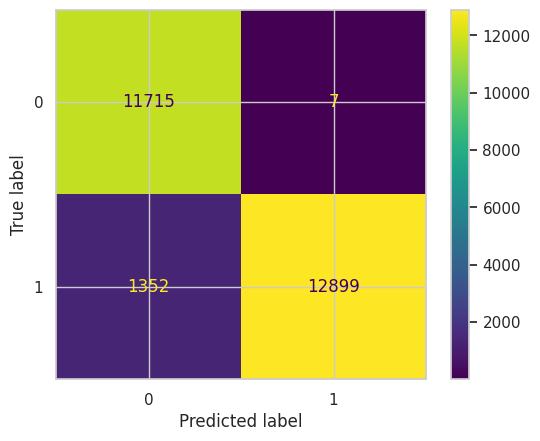

In [ ]:
accuracy_mlp = clf_mlp.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_mlp))

prediction_mlp = clf_mlp.predict(XTest)
cm_mlp = confusion_matrix(prediction_mlp, yTest)
cr_mlp = classification_report(prediction_mlp, yTest)
print('Metricas de Classificação: \n')
print(cr_mlp)
print('Confusion Matrix: \n')
print(cm_mlp)
ConfusionMatrixDisplay.from_predictions(prediction_mlp, yTest)

### Floresta Aleatória (Random forest)

In [ ]:
clf_rf = RandomForestClassifier()

In [ ]:
clf_rf = clf_rf.fit(XTrain, yTrain)

Acuracia: 
0.9991529665421784
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13059
           1       1.00      1.00      1.00     12914

    accuracy                           1.00     25973
   macro avg       1.00      1.00      1.00     25973
weighted avg       1.00      1.00      1.00     25973

Confusion Matrix: 

[[13052     7]
 [   15 12899]]


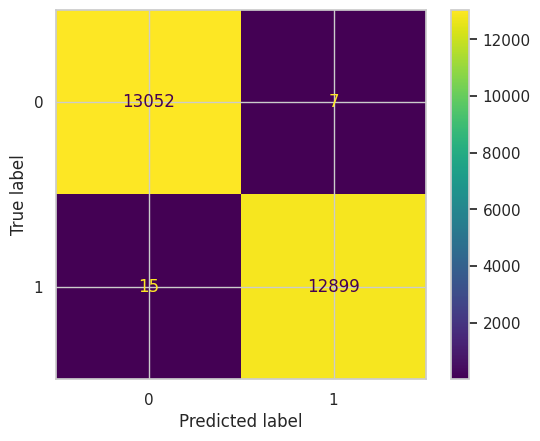

In [ ]:
accuracy_rf = clf_rf.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_rf))

prediction_rf = clf_rf.predict(XTest)
cm_rf = confusion_matrix(prediction_rf, yTest)
cr_rf = classification_report(prediction_rf, yTest)
print('Metricas de Classificação: \n')
print(cr_rf)
print('Confusion Matrix: \n')
print(cm_rf)
ConfusionMatrixDisplay.from_predictions(prediction_rf, yTest)

### Gradient Boosting Classifier

In [ ]:
clf_gb = GradientBoostingClassifier()

In [ ]:
clf_gb = clf_gb.fit(XTrain, yTrain)

Acuracia: 
0.6456705039849074
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.61      0.66      0.63     12122
           1       0.68      0.63      0.66     13851

    accuracy                           0.65     25973
   macro avg       0.65      0.65      0.65     25973
weighted avg       0.65      0.65      0.65     25973

Confusion Matrix: 

[[7993 4129]
 [5074 8777]]


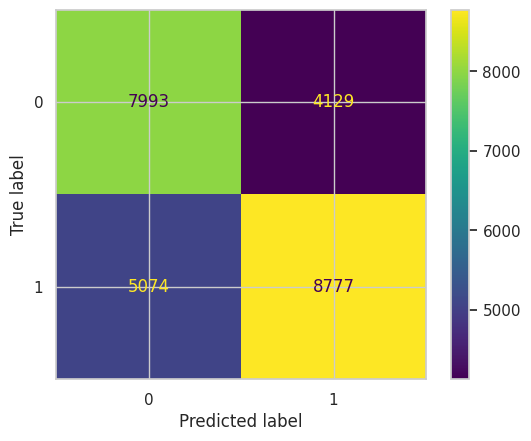

In [ ]:
accuracy_gb = clf_gb.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_gb))

prediction_gb = clf_gb.predict(XTest)
cm_gb = confusion_matrix(prediction_gb, yTest)
cr_gb = classification_report(prediction_gb, yTest)
print('Metricas de Classificação: \n')
print(cr_gb)
print('Confusion Matrix: \n')
print(cm_gb)
ConfusionMatrixDisplay.from_predictions(prediction_gb, yTest)

### Xgboost


In [ ]:
clf_xgb = XGBClassifier()

In [ ]:
clf_xgb = clf_xgb.fit(XTrain, yTrain)

Acuracia: 
0.7962884533939091
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.73      0.85      0.78     11258
           1       0.87      0.76      0.81     14715

    accuracy                           0.80     25973
   macro avg       0.80      0.80      0.80     25973
weighted avg       0.81      0.80      0.80     25973

Confusion Matrix: 

[[ 9517  1741]
 [ 3550 11165]]


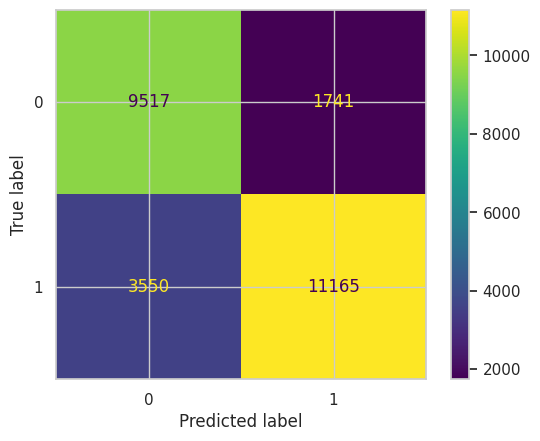

In [ ]:
accuracy_xgb = clf_xgb.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_xgb))

prediction_xgb = clf_xgb.predict(XTest)
cm_xgb = confusion_matrix(prediction_xgb, yTest)
cr_xgb = classification_report(prediction_xgb, yTest)
print('Metricas de Classificação: \n')
print(cr_xgb)
print('Confusion Matrix: \n')
print(cm_xgb)
ConfusionMatrixDisplay.from_predictions(prediction_xgb, yTest)

### Light Gradient Boosting Model (LGBM)


In [ ]:
clf_lgbm = LGBMClassifier()

In [ ]:
clf_lgbm = clf_lgbm.fit(XTrain, yTrain)

[LightGBM] [Info] Number of positive: 30381, number of negative: 30220
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 60601, number of used features: 214
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501328 -> initscore=0.005313
[LightGBM] [Info] Start training from score 0.005313


Acuracia: 
0.7436953759673507
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.69      0.77      0.73     11672
           1       0.80      0.72      0.76     14301

    accuracy                           0.74     25973
   macro avg       0.74      0.75      0.74     25973
weighted avg       0.75      0.74      0.74     25973

Confusion Matrix: 

[[ 9041  2631]
 [ 4026 10275]]


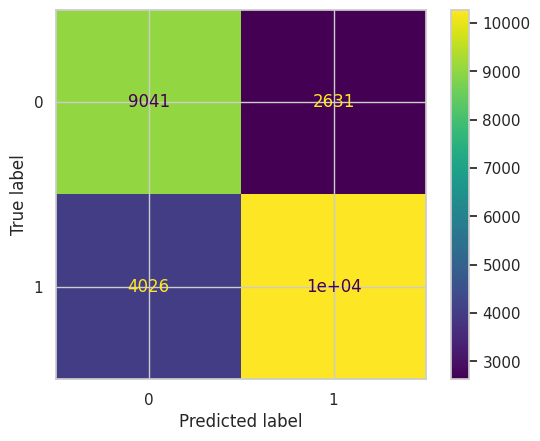

In [ ]:
accuracy_lgbm = clf_lgbm.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_lgbm))

prediction_lgbm = clf_lgbm.predict(XTest)
cm_lgbm = confusion_matrix(prediction_lgbm, yTest)
cr_lgbm = classification_report(prediction_lgbm, yTest)
print('Metricas de Classificação: \n')
print(cr_lgbm)
print('Confusion Matrix: \n')
print(cm_lgbm)
ConfusionMatrixDisplay.from_predictions(prediction_lgbm, yTest)